In [1]:
from nlp_tweets.preprocess import clean_text, get_sequences, get_embedding_matrix
from nlp_tweets.model import get_model
from nlp_tweets.eda import plot_roc_curve_mean, get_categorial_confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yannhallouard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
PATH_RAW = '../data/raw/'
PATH_PROCESSED = '../data/processed/'

TRAIN_COLUMNS = ['id', 'text', 'target']
TEST_COLUMNS = ['id', 'text']
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 50

# Loading

In [3]:
tweets_df = pd.read_csv(PATH_RAW + 'train.csv')
tweets_df = tweets_df[TRAIN_COLUMNS]
tweets_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweets_test_df = pd.read_csv(PATH_RAW + 'test.csv')
tweets_test_df = tweets_test_df[TEST_COLUMNS]

# Preprocessing

In [5]:
tweets_df['text'] = tweets_df['text'].map(lambda x: clean_text(x))

In [6]:
data, tokenizer = get_sequences(vocabulary_size=MAX_NB_WORDS, maxlen=MAX_SEQUENCE_LENGTH, texts=tweets_df['text'])

In [7]:
test_data, _ = get_sequences(vocabulary_size=MAX_NB_WORDS, maxlen=MAX_SEQUENCE_LENGTH, 
                          texts=tweets_test_df['text'], tokenizer=tokenizer)

In [8]:
pretrained_embeddings_path = PATH_RAW + "GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

In [9]:
embedding_matrix = get_embedding_matrix(tokenizer=tokenizer, 
                                        word2vec=word2vec, 
                                        max_nb_words=MAX_NB_WORDS, 
                                        enbedding_dim=EMBEDDING_DIM)

# Train test split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(data, tweets_df['target'], test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val)

print(X_train.shape, X_val.shape, X_test.shape)

(4567, 50) (2284, 50) (762, 50)


# Create Model

In [11]:
model = get_model(vocabulary_size=MAX_NB_WORDS, embeding_dim=EMBEDDING_DIM, 
                  max_sequence_length=MAX_SEQUENCE_LENGTH,_rnn_nb=[128, 64, 32], _fc_nb=[32, 16], dropout_rate=0.5) 
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           6000000   
_________________________________________________________________
gru (GRU)                    (None, 50, 128)           165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 50, 64)            37248     
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 32)            9408      
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 32)            1056      
_________________________________________________________________
dropout (Dropout)            (None, 50, 32)           

# Train

In [12]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
)

Epoch 1/100
72/72 [==============================] - 20s 271ms/step - loss: 0.8531 - accuracy: 0.5220 - val_loss: 0.7061 - val_accuracy: 0.5635
Epoch 2/100
72/72 [==============================] - 18s 245ms/step - loss: 0.7876 - accuracy: 0.5485 - val_loss: 0.6665 - val_accuracy: 0.6042
Epoch 3/100
72/72 [==============================] - 18s 247ms/step - loss: 0.7401 - accuracy: 0.5673 - val_loss: 0.7369 - val_accuracy: 0.5285
Epoch 4/100
72/72 [==============================] - 18s 250ms/step - loss: 0.7194 - accuracy: 0.5704 - val_loss: 0.6786 - val_accuracy: 0.6230
Epoch 5/100
72/72 [==============================] - 19s 263ms/step - loss: 0.6873 - accuracy: 0.5943 - val_loss: 0.7868 - val_accuracy: 0.5665
Epoch 6/100
72/72 [==============================] - 18s 249ms/step - loss: 0.6777 - accuracy: 0.5975 - val_loss: 0.7460 - val_accuracy: 0.5595
Epoch 7/100
72/72 [==============================] - 18s 251ms/step - loss: 0.6517 - accuracy: 0.6214 - val_loss: 0.5963 - val_accuracy:

72/72 [==============================] - 18s 249ms/step - loss: 0.5486 - accuracy: 0.7449 - val_loss: 0.5779 - val_accuracy: 0.7329
Epoch 58/100
72/72 [==============================] - 18s 247ms/step - loss: 0.5494 - accuracy: 0.7528 - val_loss: 0.6039 - val_accuracy: 0.6988
Epoch 59/100
72/72 [==============================] - 18s 246ms/step - loss: 0.5381 - accuracy: 0.7616 - val_loss: 0.5615 - val_accuracy: 0.7369
Epoch 60/100
72/72 [==============================] - 18s 249ms/step - loss: 0.5561 - accuracy: 0.7445 - val_loss: 0.5682 - val_accuracy: 0.7246
Epoch 61/100
72/72 [==============================] - 18s 251ms/step - loss: 0.5412 - accuracy: 0.7478 - val_loss: 0.5609 - val_accuracy: 0.7347
Epoch 62/100
72/72 [==============================] - 18s 249ms/step - loss: 0.5470 - accuracy: 0.7489 - val_loss: 0.5812 - val_accuracy: 0.7194
Epoch 63/100
72/72 [==============================] - 18s 246ms/step - loss: 0.5332 - accuracy: 0.7554 - val_loss: 0.5584 - val_accuracy: 0.735

## Finding the best threshold

In [13]:
pred_proba_train = model.predict(X_train)
pred_proba_val = model.predict(X_val)

Train Accuracy: 0.8552660389752573 
Train Confusion Matrix:
[[2434  166]
 [ 495 1472]]
Test Accuracy: 0.7495621716287215 
Test Confusion Matrix:
[[1132  155]
 [ 417  580]]


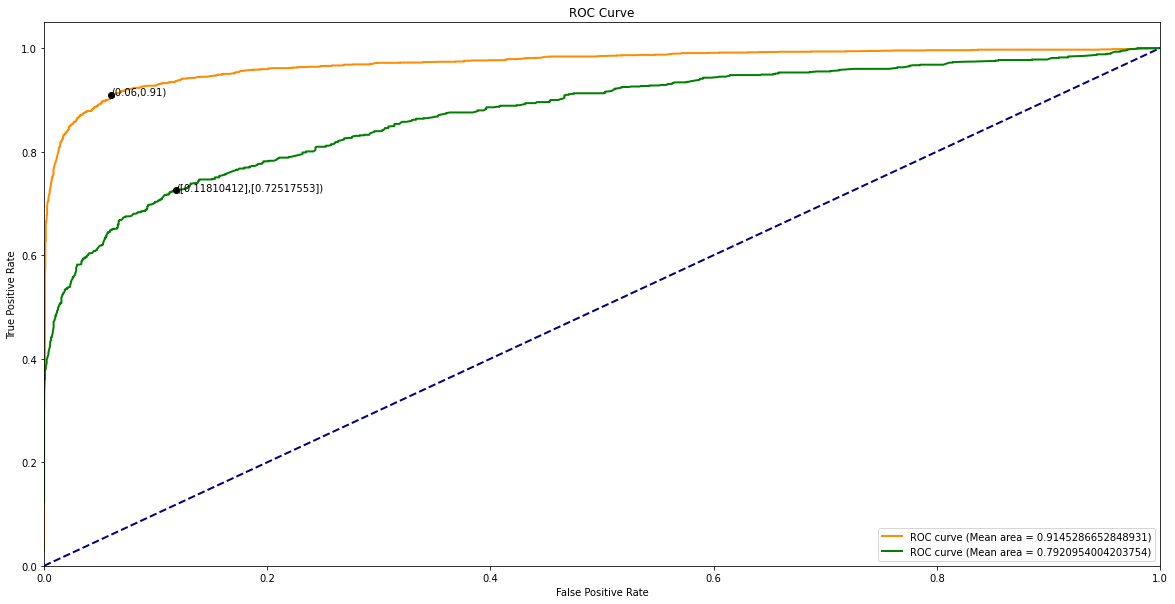

In [14]:
threshold = plot_roc_curve_mean(y_train=y_train.values, y_train_pred_proba=pred_proba_train, 
                        y_test=y_val.values, y_test_pred_proba=pred_proba_val)

## Test

In [15]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 1s 26ms/step - loss: 0.5228 - accuracy: 0.7717


[0.5227630138397217, 0.7716535329818726]

In [16]:
pred_proba_test = model.predict(X_test).reshape(-1)
pred_proba_test = (pred_proba_test > threshold).astype(int)

array([[404.,  51.],
       [118., 189.]])

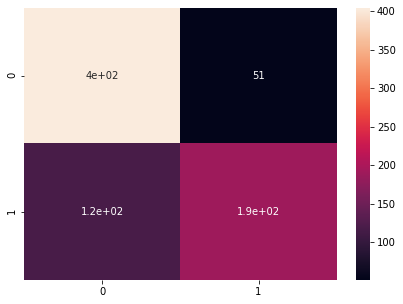

In [17]:
get_categorial_confusion_matrix(y_test, pred_proba_test, display=True)

# Predict

In [18]:
predictions = model.predict(test_data)
predictions = (predictions > threshold).astype(int)

In [19]:
output = pd.read_csv(PATH_RAW + 'sample_submission.csv')
output['target'] = predictions
output.to_csv(PATH_PROCESSED + 'to_submit.csv', index=False)